In [1]:
# Import library
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)

#Train validation split
train_subset, val_subset = torch.utils.data.random_split(
        train_dataset, [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)], 
        generator=torch.Generator().manual_seed(1))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_subset, 
                                           batch_size=50, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_subset, 
                                           batch_size=50, 
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=50, 
                                          shuffle=False)

In [3]:
# Define neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 25, kernel_size=12, stride=2), 
            nn.ReLU())                                   
            
        self.conv2 = nn.Sequential(
            nn.Conv2d(25, 64, kernel_size=5, stride=1, padding=2), 
            nn.ReLU())   

        self.fc1 = nn.Sequential(
            nn.Linear(4*4*64, 1024),
            nn.ReLU())
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.conv1(x)                           #28*28*1  -> 9*9*25
        x = self.conv2(x)                           #9*9*25   -> 9*9*64
        x = F.max_pool2d(x,kernel_size=2, stride=2) #9*9*64   -> 4*4*64
        x = x.view(x.size(0), -1)                   #4*4*64   -> 1*1*1024
        x = self.fc1(x)                             #1*1*1024 -> 1*1*1024
        x = self.fc2(x)                             #1*1*1024 -> 1*1*10
        return x

In [4]:
#Move model to the configured device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) 

In [5]:
# Training Parameters
total_step = len(train_loader)
iteration = 0
num_iteration = 5000

# Training
while iteration < num_iteration:
    for i, (images, labels) in enumerate(train_loader):  
        iteration+= 1

        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Calculate validation accuracy
        if iteration % 100 == 0:
            model.eval()
            correct = 0
            total = 0
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print ('Iteration [{}/{}], Loss: {:.4f}, Validation accuracy: {:.2f} %' 
               .format(iteration, num_iteration, loss.item(), 100 * correct / total))

        if iteration == num_iteration:
            break

Iteration [100/5000], Loss: 0.9018, Validation accuracy: 81.79 %
Iteration [200/5000], Loss: 0.4938, Validation accuracy: 86.08 %
Iteration [300/5000], Loss: 0.4138, Validation accuracy: 88.72 %
Iteration [400/5000], Loss: 0.3164, Validation accuracy: 90.07 %
Iteration [500/5000], Loss: 0.2495, Validation accuracy: 91.00 %
Iteration [600/5000], Loss: 0.2203, Validation accuracy: 90.76 %
Iteration [700/5000], Loss: 0.1701, Validation accuracy: 92.83 %
Iteration [800/5000], Loss: 0.2324, Validation accuracy: 93.29 %
Iteration [900/5000], Loss: 0.2461, Validation accuracy: 94.00 %
Iteration [1000/5000], Loss: 0.2269, Validation accuracy: 94.51 %
Iteration [1100/5000], Loss: 0.2265, Validation accuracy: 94.90 %
Iteration [1200/5000], Loss: 0.2219, Validation accuracy: 95.47 %
Iteration [1300/5000], Loss: 0.0957, Validation accuracy: 95.22 %
Iteration [1400/5000], Loss: 0.2027, Validation accuracy: 95.72 %
Iteration [1500/5000], Loss: 0.0569, Validation accuracy: 95.90 %
Iteration [1600/500

In [6]:
# Test accuracy
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy on 10000 test images: {} %'.format(100 * correct / total))


Accuracy on 10000 test images: 98.54 %


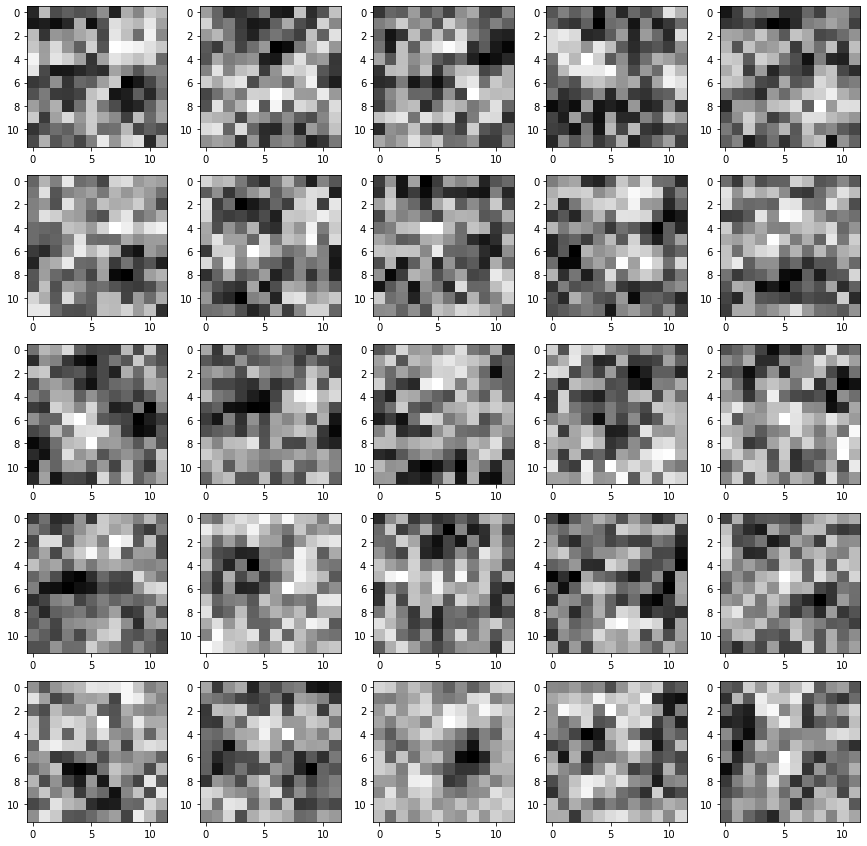

In [7]:
# Visualize and save filter images 
plt.figure(figsize=(15, 15))
for i, filter in enumerate(model.conv1[0].weight):
    plt.subplot(5, 5, i+1) 
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='gray')
    plt.savefig('/workspace/project/ML-assignment2/filter.png')
plt.show()